# Look at specific waves of the pandemic

In [21]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
from Functions import add_labels_to_subplots, merge_and_rename_data, pivot_data_by_HSA, create_column_names, create_collated_weekly_data, add_changes_by_week, calculate_metrics, merge_and_rename_data, add_changes_by_week, determine_covid_outcome_indicator, prep_training_test_data_period, prep_training_test_data, prep_training_test_data_shifted, cross_validation_leave_geo_out
import random
import sklearn.metrics 

#from Functions import add_labels_to_subplots, merge_and_rename_data, pivot_data_by_HSA, create_column_names, create_collated_weekly_data, add_changes_by_week, prep_training_test_data_period, prep_training_test_data, calculate_ppv_npv, merge_and_rename_data, add_changes_by_week, determine_covid_outcome_indicator
hfont = {'fontname':'Helvetica'}

#oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=10) #need for neural network and random forest
import pickle


In [22]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

data_by_HSA['date'] = pd.to_datetime(data_by_HSA['date'])


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_31008/448745239.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


# Delta 
mid-July 2021 to December 2021

In [182]:
start_date = pd.to_datetime('2021-07-15')
end_date = pd.to_datetime('2021-12-01')
data_by_HSA_delta_wave = data_by_HSA[(data_by_HSA['date'] >= start_date) & (data_by_HSA['date'] <= end_date)]


In [190]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Accuracy: 0.9008135168961201
auROC: 0.80641224356887
[[  88   37]
 [ 280 2791]]


[Text(0.375, 0.9166666666666666, 'icu <= 0.061\ngini = 0.5\nsamples = 10387\nvalue = [6.468, 6.468]'),
 Text(0.16666666666666666, 0.75, 'beds <= 2.319\ngini = 0.238\nsamples = 1822\nvalue = [6.289, 1.005]'),
 Text(0.08333333333333333, 0.5833333333333334, 'gini = 0.105\nsamples = 645\nvalue = [4.889, 0.289]'),
 Text(0.25, 0.5833333333333334, 'cases <= 302.5\ngini = 0.448\nsamples = 1177\nvalue = [1.4, 0.716]'),
 Text(0.16666666666666666, 0.4166666666666667, 'gini = 0.398\nsamples = 741\nvalue = [1.171, 0.444]'),
 Text(0.3333333333333333, 0.4166666666666667, 'gini = 0.496\nsamples = 436\nvalue = [0.229, 0.273]'),
 Text(0.5833333333333334, 0.75, 'beds <= 21.853\ngini = 0.061\nsamples = 8565\nvalue = [0.178, 5.462]'),
 Text(0.5, 0.5833333333333334, 'gini = 0.453\nsamples = 380\nvalue = [0.127, 0.239]'),
 Text(0.6666666666666666, 0.5833333333333334, 'delta_perc <= 0.042\ngini = 0.019\nsamples = 8185\nvalue = [0.051, 5.223]'),
 Text(0.5, 0.4166666666666667, 'admits <= 9.962\ngini = 0.117\nsa

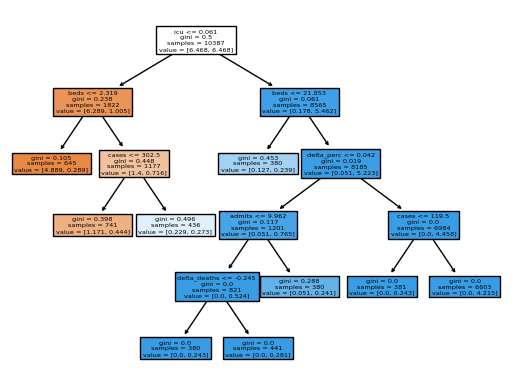

In [191]:
param_grid = {
    'criterion': ['gini',  'entropy'],
    'max_depth': np.arange(2, 20),
    'min_samples_split':  np.arange(100, 1000, 20), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 1000, 20)} #100, 200, 300, 400, 500], #np.arange(500, 200)}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)


In [192]:
model_name = f"CDC_full_auroc_{ROC:.4f}_period_delta_wave.sav"
pickle.dump(clf, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

# Shifted time period 

In [193]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)

In [194]:
y_train_shifted = y_train.shift(-1)
y_test_shifted = y_test.shift(-1)

y_train_shifted.drop(index=y_train_shifted.index[-1], inplace=True)
y_test_shifted.drop(index=y_test_shifted.index[-1], inplace=True)
X_train.drop(index=X_train.index[-1], inplace=True)
X_test.drop(index=X_test.index[-1], inplace=True)
weights.drop(index=weights.index[-1], inplace=True)
weights = weights[0].to_numpy()

In [74]:
best_params

{'min_samples_split': 452,
 'min_samples_leaf': 352,
 'max_depth': 4,
 'criterion': 'entropy'}

Accuracy: 0.6735524256651018
auROC: 0.6037394136807818
[[  66   59]
 [ 984 2086]]


[Text(0.5, 0.875, 'icu <= 0.387\nentropy = 1.0\nsamples = 10386\nvalue = [6.467, 6.467]'),
 Text(0.25, 0.625, 'delta_icu <= -0.0\nentropy = 0.87\nsamples = 2185\nvalue = [3.208, 1.314]'),
 Text(0.125, 0.375, 'delta_deaths <= -1.58\nentropy = 0.996\nsamples = 1283\nvalue = [0.917, 0.796]'),
 Text(0.0625, 0.125, 'entropy = 0.851\nsamples = 293\nvalue = [0.458, 0.176]'),
 Text(0.1875, 0.125, 'entropy = 0.984\nsamples = 990\nvalue = [0.458, 0.62]'),
 Text(0.375, 0.375, 'delta_deaths <= -2.58\nentropy = 0.69\nsamples = 902\nvalue = [2.291, 0.518]'),
 Text(0.3125, 0.125, 'entropy = 0.996\nsamples = 106\nvalue = [0.076, 0.066]'),
 Text(0.4375, 0.125, 'entropy = 0.657\nsamples = 796\nvalue = [2.215, 0.453]'),
 Text(0.75, 0.625, 'delta_deaths <= 1.382\nentropy = 0.963\nsamples = 8201\nvalue = [3.259, 5.153]'),
 Text(0.625, 0.375, 'delta_deaths <= -4.453\nentropy = 0.907\nsamples = 6524\nvalue = [1.96, 4.115]'),
 Text(0.5625, 0.125, 'entropy = 0.954\nsamples = 448\nvalue = [0.458, 0.274]'),
 Tex

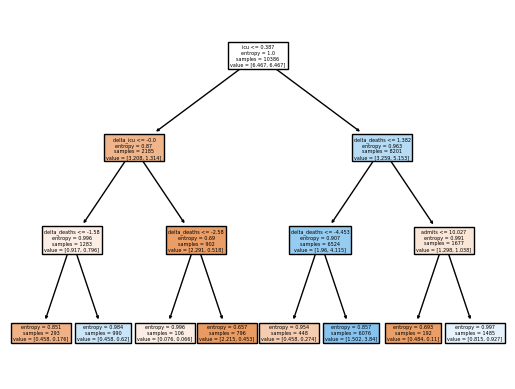

In [195]:
param_grid = {
    'criterion': ['entropy'],
    'max_depth': np.arange(2,20),
    'min_samples_split': np.arange(2, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(2, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf_shifted = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf_shifted, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train_shifted, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf_shifted = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf_shifted.fit(X_train, y_train_shifted,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_shifted.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_shifted, y_pred)
ROC = roc_auc_score(y_test_shifted, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test_shifted, y_pred))
plot_tree(clf_shifted, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)

In [196]:
model_name = f"CDC_full_auroc_{ROC:.4f}_shifted_delta_wave.sav"
pickle.dump(clf_shifted, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

# Exact time

In [268]:

### this code it's ANY in the x week period
def prep_training_test_data(
    data, no_weeks, weeks_in_future, if_train, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1
        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        if if_train:
            X_week, y_week = oversample.fit_resample(X_week, y_week)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

            # rename columns for concatenation
        y_week.columns = range(1, len(data_y.columns) - 1)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)

In [85]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()

Accuracy: 0.7459324155193993
auROC: 0.8253490611458836
[[ 228   20]
 [ 792 2156]]


[Text(0.47058823529411764, 0.9, 'icu <= 0.387\nentropy = 1.0\nsamples = 10386\nvalue = [6.467, 6.467]'),
 Text(0.23529411764705882, 0.7, 'delta_icu <= -0.0\nentropy = 0.87\nsamples = 2185\nvalue = [3.208, 1.314]'),
 Text(0.11764705882352941, 0.5, 'delta_deaths <= -1.58\nentropy = 0.996\nsamples = 1283\nvalue = [0.917, 0.796]'),
 Text(0.058823529411764705, 0.3, 'entropy = 0.851\nsamples = 293\nvalue = [0.458, 0.176]'),
 Text(0.17647058823529413, 0.3, 'deaths <= 0.893\nentropy = 0.984\nsamples = 990\nvalue = [0.458, 0.62]'),
 Text(0.11764705882352941, 0.1, 'entropy = 0.0\nsamples = 349\nvalue = [0.0, 0.223]'),
 Text(0.23529411764705882, 0.1, 'entropy = 0.996\nsamples = 641\nvalue = [0.458, 0.398]'),
 Text(0.35294117647058826, 0.5, 'deaths <= 2.465\nentropy = 0.69\nsamples = 902\nvalue = [2.291, 0.518]'),
 Text(0.29411764705882354, 0.3, 'entropy = 0.632\nsamples = 650\nvalue = [1.935, 0.366]'),
 Text(0.4117647058823529, 0.3, 'entropy = 0.88\nsamples = 252\nvalue = [0.356, 0.152]'),
 Text(

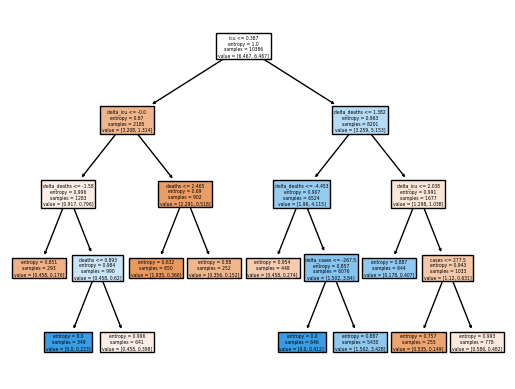

In [88]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 20, 2),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf_exact = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf_exact, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_
best_params = {'min_samples_split': 350,
 'min_samples_leaf': 300,
 'max_depth': 10,
 'criterion': 'entropy'}
# Create the Decision Tree classifier with the best hyperparameters
#clf = DecisionTreeClassifier(**best_params, random_state=100, class_weight='balanced')
clf_exact = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf_exact.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf_exact.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)
print(confusion_matrix(y_test, y_pred))
plot_tree(clf_exact, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)

In [ ]:
model_name = f"CDC_full_auroc_{ROC:.4f}_exact_delta_wave.sav"
pickle.dump(clf_exact, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

# omicron 
DEcember 2021 - September 20 2022 (Alyssa's paper)

In [197]:
start_date = pd.to_datetime('2021-12-01')
end_date = pd.to_datetime('2022-09-20')
data_by_HSA_omicron_wave = data_by_HSA[(data_by_HSA['date'] >= start_date) & (data_by_HSA['date'] <= end_date)]

Accuracy: 0.8927067925816361
auROC: 0.8166516169084034
[[ 445  166]
 [ 777 7401]]


[Text(0.46153846153846156, 0.9375, 'beds <= 20.054\ngini = 0.5\nsamples = 22372\nvalue = [13.93, 13.93]'),
 Text(0.28846153846153844, 0.8125, 'beds <= 10.528\ngini = 0.281\nsamples = 7216\nvalue = [12.601, 2.566]'),
 Text(0.19230769230769232, 0.6875, 'admits <= 1.927\ngini = 0.191\nsamples = 4863\nvalue = [10.478, 1.257]'),
 Text(0.11538461538461539, 0.5625, 'cases <= 58.5\ngini = 0.136\nsamples = 3108\nvalue = [7.557, 0.599]'),
 Text(0.07692307692307693, 0.4375, 'deaths <= 3.064\ngini = 0.104\nsamples = 2121\nvalue = [5.518, 0.323]'),
 Text(0.038461538461538464, 0.3125, 'gini = 0.138\nsamples = 982\nvalue = [2.376, 0.192]'),
 Text(0.11538461538461539, 0.3125, 'gini = 0.077\nsamples = 1139\nvalue = [3.141, 0.131]'),
 Text(0.15384615384615385, 0.4375, 'gini = 0.21\nsamples = 987\nvalue = [2.039, 0.276]'),
 Text(0.2692307692307692, 0.5625, 'cases <= 50.5\ngini = 0.3\nsamples = 1755\nvalue = [2.921, 0.658]'),
 Text(0.23076923076923078, 0.4375, 'gini = 0.211\nsamples = 847\nvalue = [1.747,

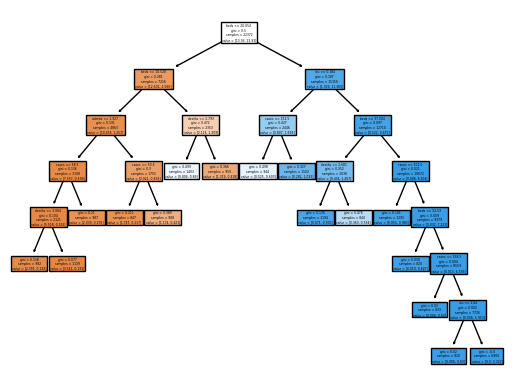

In [200]:
param_grid = {
    'criterion': ['gini',  'entropy'],
    'max_depth': np.arange(2, 10),
    'min_samples_split':  np.arange(100, 1000, 20), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 1000, 20)} #100, 200, 300, 400, 500], #np.arange(500, 200)}

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train,  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC) 

print(confusion_matrix(y_test, y_pred))
plot_tree(clf, feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], filled=True)

In [201]:
model_name = f"CDC_full_auroc_{ROC:.4f}_period_omicron_wave.sav"
pickle.dump(clf, open(model_name, 'wb'))
#clf = pickle.load(open(model_name, 'rb'))

# CDC classifier period 
March 1st 2021 - Jan 24th 2022

Only using the CDC classifier features

In [23]:
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_HSA_CDC_dates = data_by_HSA[(data_by_HSA['date'] >= start_date) & (data_by_HSA['date'] <= end_date)]

for i, week in enumerate(data_by_HSA_CDC_dates['date'].unique()):
    data_by_HSA_CDC_dates.loc[data_by_HSA_CDC_dates['date'] == week, 'week'] = i

In [24]:
## pivot
data_by_HSA_CDC_dates_cases = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_CDC_dates_admissions = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_CDC_dates_percent_beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_CDC_dates_over_15_100k = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge (incl outcome)
data_by_HSA_CDC_dates_cases_admits = merge_and_rename_data(data_by_HSA_CDC_dates_cases, data_by_HSA_CDC_dates_admissions,'week','cases', 'admits')

data_by_HSA_CDC_dates_admits_perc_outcome = merge_and_rename_data(data_by_HSA_CDC_dates_percent_beds, data_by_HSA_CDC_dates_over_15_100k,'week','perc_covid', 'beds_over_15_100k')
data_by_HSA_CDC_dates_cases_admits_perc_outcome= pd.merge(data_by_HSA_CDC_dates_cases_admits, data_by_HSA_CDC_dates_admits_perc_outcome, on='week')

data_by_HSA_CDC_dates_cases_admits_perc_outcome = data_by_HSA_CDC_dates_cases_admits_perc_outcome.reset_index()
data_by_HSA_CDC_dates_cases_admits_perc_outcome.columns = data_by_HSA_CDC_dates_cases_admits_perc_outcome.columns.str.replace(',', '')

## collate weekly data
categories_for_subsetting = ['cases', 'admits','perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_CDC_dates_cases_admits_perc_outcome)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_CDC_dates_cases_admits_perc_outcome, data_by_HSA_CDC_dates, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns={'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

In [25]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
weights = weights[0].to_numpy()

In [26]:
no_iterations = 10  
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(num_of_weeks*2/3) + 1)  # First 6 months initially 
no_weeks_test = range(int(num_of_weeks*2/3) + 1, num_of_weeks -2)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

Accuracy: 0.9
auROC: 0.7602994430565424
[[ 348  296]
 [ 744 9012]]


[Text(0.5, 0.8333333333333334, 'Percent Covid <= 0.02\nsamples = 24800\nvalue = [15.442, 15.442]\nclass = Above'),
 Text(0.25, 0.5, 'Percent Covid <= 0.001\nsamples = 8802\nvalue = [11.869, 3.676]\nclass = Below'),
 Text(0.125, 0.16666666666666666, 'samples = 3509\nvalue = [6.996, 0.826]\nclass = Below'),
 Text(0.375, 0.16666666666666666, 'samples = 5293\nvalue = [4.873, 2.85]\nclass = Below'),
 Text(0.75, 0.5, 'Cases <= 105.5\nsamples = 15998\nvalue = [3.573, 11.766]\nclass = Above'),
 Text(0.625, 0.16666666666666666, 'samples = 6234\nvalue = [2.626, 4.236]\nclass = Above'),
 Text(0.875, 0.16666666666666666, 'samples = 9764\nvalue = [0.947, 7.53]\nclass = Above')]

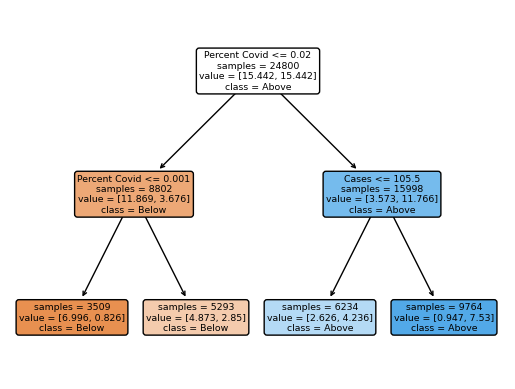

In [16]:

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['Cases', 'Admits','Percent Covid'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=3)


In [17]:
model_name = f"CDC_classifier_auroc_{ROC:.4f}_CDC_period.sav"
pickle.dump(clf, open(model_name, 'wb'))

Now do CDC outcomes

In [102]:
CDC_predictions_levels = pd.DataFrame(index=data_by_HSA_CDC_dates_cases_admits_perc_outcome['week'])
indicators, actual_outcome, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(1, 45), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = False)
weights = weights[0].to_numpy()
for idx, row in indicators.iterrows():
    outcome = determine_covid_outcome_indicator(row[1], row[2], row[3])
    CDC_predictions_levels.at[idx, 0] = outcome

In [104]:

# Calculate the percentage of cases where the predicted CDC risk level is 'High' and actual outcome is 1
sum_high_and_1 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 1))
total_high_predictions = np.sum(CDC_predictions_levels == 'High')
percentage_high_and_1 = (sum_high_and_1 / total_high_predictions) * 100
print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))

# Calculate the percentage of cases where the predicted CDC risk level is 'Medium' and actual outcome is 1
sum_med_and_1 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 1))
total_med_predictions = np.sum(CDC_predictions_levels == 'Medium')
percentage_med_and_1 = (sum_med_and_1 / total_med_predictions) * 100
print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))

# Calculate the percentage of cases where the predicted CDC risk level is 'Low' and actual outcome is 1
sum_low_and_1 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 1))
total_low_predictions = np.sum(CDC_predictions_levels == 'Low')
percentage_low_and_1 = (sum_low_and_1 / total_low_predictions) * 100
print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))

Percentage High and 1: 95.84%
Percentage Medium and 1: 87.20%
Percentage Low and 1: 70.99%


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1493/831232160.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1493/831232160.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_1493/831232160.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))


In [106]:
replacement_map = {'Low': 0, 'Medium': 0, 'High': 1}

# Replace values in the 'CDC_predictions_levels' column
CDC_predictions_levels_binary = CDC_predictions_levels[0].replace(replacement_map)


In [113]:
# Calculate the True Positive Rate (Sensitivity) and False Positive Rate for different levels
tpr_high = sum_high_and_1 / total_high_predictions
fpr_high = (total_high_predictions - sum_high_and_1) / total_high_predictions

tpr_med = (total_med_predictions - sum_med_and_1) / total_med_predictions
fpr_med = sum_med_and_1 / total_med_predictions

tpr_low = (total_low_predictions - sum_low_and_1) / total_low_predictions
fpr_low = sum_low_and_1 / total_low_predictions

# Create ROC curve points
roc_points = [(fpr_low, tpr_low), (fpr_med, tpr_med), (fpr_high, tpr_high)]

# Calculate AUROC score
auroc_score = roc_auc_score(actual_outcome, CDC_predictions_levels_binary)


<Figure size 800x600 with 0 Axes>

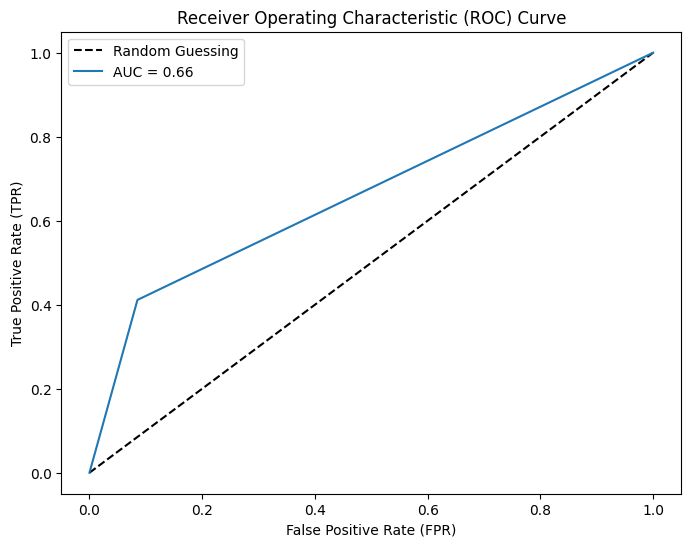

In [131]:

# Plot the ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(actual_outcome, CDC_predictions_levels_binary)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Plot the diagonal line representing random guessing
plt.plot(fpr, tpr, label=f'AUC = {auroc_score:.2f}')  # Plot the ROC curve
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(['Random Guessing', f'AUC = {auroc_score:.2f}'])


In [111]:
auroc_score

0.6631454936040726

Compare to naive classifier for this period

In [27]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0].to_numpy()
X_train_naive = X_train.iloc[:, -1].values.reshape(-1, 1)
X_test_naive = X_test.iloc[:, -1].values.reshape(-1, 1)

In [29]:
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train_naive, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train_naive, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test_naive)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)


MCC: 0.7145570051904345
Accuracy: 0.931923076923077
auROC: 0.7200652441307022


# Classifier B

In [30]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(1, int(num_of_weeks*2/3) + 1), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data(all_HSA_ID_weekly_data,   no_weeks = range(int(num_of_weeks*2/3) + 1, num_of_weeks-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)

In [32]:
weights = weights[0]

In [ ]:
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation

best_params = cross_validation_leave_geo_out(all_HSA_ID_weekly_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba[:,1])
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['Cases', 'Admits','Percent Covid'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=3)

MCC: 0.7145570051904345
Accuracy: 0.931923076923077
auROC: 0.7975111350492388
[[ 308  336]
 [ 372 9384]]


[Text(0.5, 0.8333333333333334, 'Current capacity <= 0.5\nsamples = 24800\nvalue = [15.442, 15.442]\nclass = Above'),
 Text(0.25, 0.5, 'Percent Covid <= 0.001\nsamples = 5851\nvalue = [9.874, 1.883]\nclass = Below'),
 Text(0.125, 0.16666666666666666, 'samples = 3507\nvalue = [6.996, 0.824]\nclass = Below'),
 Text(0.375, 0.16666666666666666, 'samples = 2344\nvalue = [2.878, 1.059]\nclass = Below'),
 Text(0.75, 0.5, 'Percent Covid <= 0.037\nsamples = 18949\nvalue = [5.569, 13.559]\nclass = Above'),
 Text(0.625, 0.16666666666666666, 'samples = 7938\nvalue = [4.22, 5.147]\nclass = Above'),
 Text(0.875, 0.16666666666666666, 'samples = 11011\nvalue = [1.348, 8.412]\nclass = Above')]

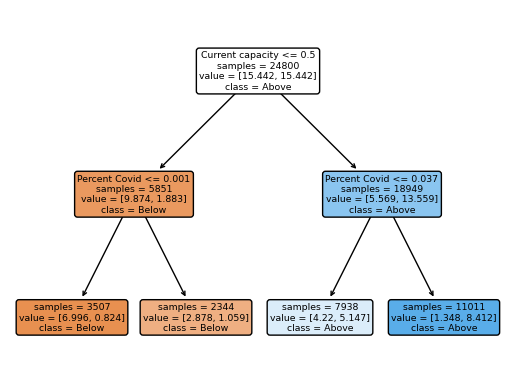

In [34]:

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred_proba[:,1])
MCC = (matthews_corrcoef(y_test, y_pred) + 1)/2

print("MCC:", MCC)
print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['Cases', 'Admits','Percent Covid', 'Current capacity'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=3)

In [35]:
model_name = f"CDC_classifier_auroc_{ROC:.4f}_CDC_period_B.sav"
pickle.dump(clf, open(model_name, 'wb'))

## Full classifier 

In [104]:
for i, week in enumerate(data_by_HSA_CDC_dates['date'].unique()):
    data_by_HSA_CDC_dates.loc[data_by_HSA_CDC_dates['date'] == week, 'week'] = i

## pivot 
data_by_HSA_CDC_dates_cases = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_CDC_dates_deaths = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_CDC_dates_admissions = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_CDC_dates_icu = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_CDC_dates_beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_CDC_dates_percent_beds = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_CDC_dates_over_15_100k = pivot_data_by_HSA(data_by_HSA_CDC_dates, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_CDC_dates_cases_deaths = merge_and_rename_data(data_by_HSA_CDC_dates_cases, data_by_HSA_CDC_dates_deaths,'week','cases', 'deaths')
data_by_HSA_CDC_dates_admits_icu_weekly = merge_and_rename_data(data_by_HSA_CDC_dates_admissions, data_by_HSA_CDC_dates_icu,'week','admits', 'icu')
data_by_HSA_CDC_dates_beds_perc_weekly = merge_and_rename_data(data_by_HSA_CDC_dates_beds, data_by_HSA_CDC_dates_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_CDC_dates_cases_deaths_admits_icu = pd.merge(data_by_HSA_CDC_dates_cases_deaths, data_by_HSA_CDC_dates_admits_icu_weekly, on='week')
data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_CDC_dates_cases_deaths_admits_icu, data_by_HSA_CDC_dates_beds_perc_weekly, on='week')

## add outcome variable 
old_column_names = data_by_HSA_CDC_dates_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_CDC_dates_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds, data_by_HSA_CDC_dates_over_15_100k, on='week')

data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds = data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds.columns = data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_CDC_dates_cases_deaths_admits_icu_beds, data_by_HSA_CDC_dates, categories_for_subsetting, 'HSA_ID', column_names)

all_HSA_ID_weekly_data = add_changes_by_week(all_HSA_ID_weekly_data, "beds_over_15_100k")

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns={'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])


/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

# Use all data before either the delta or omicron strain 

In [202]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_15_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_15_100k.columns
new_column_names = [str(col) + '_beds_over_15_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_15_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_15_100k, on='week')

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_3786/685671475.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


In [203]:
categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

In [204]:
all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

In [205]:
all_HSA_ID_weekly_data = add_changes_by_week(all_HSA_ID_weekly_data, "beds_over_15_100k")

/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) i

In [ ]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

# Delta

In [239]:
## delta indices 

start_date = pd.to_datetime('2021-07-15')
end_date = pd.to_datetime('2021-12-01')
data_by_HSA['date'] = pd.to_datetime(data_by_HSA['date'])
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_HSA.loc[data_by_HSA['date'] <= start_date].index.max()
matching_indices_end = data_by_HSA.loc[data_by_HSA['date'] <= end_date].index.max()
first_week_delta = data_by_HSA.loc[matching_indices_start, 'week']
last_week_delta = data_by_HSA.loc[matching_indices_end, 'week']


# Full classifier

In [240]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, first_week_delta -2), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(first_week_delta -1, last_week_delta-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0]

Accuracy: 0.8523812660562545
auROC: 0.8885100961873516
[[  773    59]
 [ 2182 12167]]


[Text(0.4117063492063492, 0.95, 'beds <= 21.0\nsamples = 39106\nvalue = [24.0, 24.0]\nclass = Above'),
 Text(0.20436507936507936, 0.85, 'beds <= 10.0\nsamples = 9817\nvalue = [22.0, 4.0]\nclass = Below'),
 Text(0.10714285714285714, 0.75, 'cases <= 24.0\nsamples = 6597\nvalue = [18.0, 2.0]\nclass = Below'),
 Text(0.047619047619047616, 0.65, 'admits <= 1.0\nsamples = 1659\nvalue = [6.0, 0.0]\nclass = Below'),
 Text(0.031746031746031744, 0.55, 'cases <= 12.0\nsamples = 1232\nvalue = [5.0, 0.0]\nclass = Below'),
 Text(0.015873015873015872, 0.45, 'samples = 544\nvalue = [2.0, 0.0]\nclass = Below'),
 Text(0.047619047619047616, 0.45, 'samples = 688\nvalue = [3.0, 0.0]\nclass = Below'),
 Text(0.06349206349206349, 0.55, 'samples = 427\nvalue = [1.0, 0.0]\nclass = Below'),
 Text(0.16666666666666666, 0.65, 'admits <= 0.0\nsamples = 4938\nvalue = [12.0, 2.0]\nclass = Below'),
 Text(0.1111111111111111, 0.55, 'cases <= 58.0\nsamples = 2677\nvalue = [8.0, 1.0]\nclass = Below'),
 Text(0.07936507936507

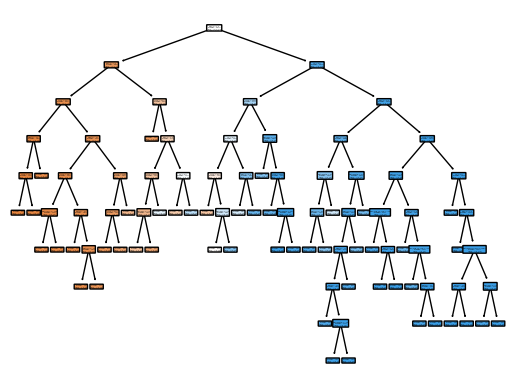

In [241]:
param_grid = {
    'criterion': [ 'entropy'],
    'max_depth': np.arange(2, 10),
    'min_samples_split':  np.arange(100, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)


In [218]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.8517666736357934
specificity:  0.8990384615384616
ppv:  0.9931740614334471
npv:  0.26017391304347826


In [242]:
model_name = f"Full_auroc_{ROC:.4f}_delta_period_unpruned.sav"
pickle.dump(clf, open(model_name, 'wb'))

In [243]:
unpruned_tree = clf
# Calculate impurity-based CCP alphas
path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Perform cross-validation for different alpha values
best_alpha = None
best_score = 0
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(ccp_alpha=alpha)
    scores = cross_val_score(pruned_tree, X_train, y_train, cv=cv)  # Use your desired cross-validation strategy
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print("Best alpha:", best_alpha)

Best alpha: 0.0004856303332424405


In [245]:
clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=200, min_samples_split=950,
                       random_state=10, ccp_alpha=best_alpha)

Accuracy: 0.8523812660562545
auROC: 0.8885100961873516
[[  773    59]
 [ 2182 12167]]


[Text(0.4105392156862745, 0.9375, 'beds <= 21.0\nsamples = 39106\nvalue = [24.0, 24.0]\nclass = Above'),
 Text(0.18137254901960784, 0.8125, 'beds <= 10.0\nsamples = 9817\nvalue = [22.0, 4.0]\nclass = Below'),
 Text(0.08823529411764706, 0.6875, 'cases <= 24.0\nsamples = 6597\nvalue = [18.0, 2.0]\nclass = Below'),
 Text(0.0392156862745098, 0.5625, 'admits <= 1.0\nsamples = 1659\nvalue = [6.0, 0.0]\nclass = Below'),
 Text(0.0196078431372549, 0.4375, 'samples = 1232\nvalue = [5.0, 0.0]\nclass = Below'),
 Text(0.058823529411764705, 0.4375, 'samples = 427\nvalue = [1.0, 0.0]\nclass = Below'),
 Text(0.13725490196078433, 0.5625, 'admits <= 0.0\nsamples = 4938\nvalue = [12.0, 2.0]\nclass = Below'),
 Text(0.09803921568627451, 0.4375, 'cases <= 58.0\nsamples = 2677\nvalue = [8.0, 1.0]\nclass = Below'),
 Text(0.0784313725490196, 0.3125, 'samples = 1127\nvalue = [4.0, 0.0]\nclass = Below'),
 Text(0.11764705882352941, 0.3125, 'samples = 1550\nvalue = [4.0, 0.0]\nclass = Below'),
 Text(0.176470588235

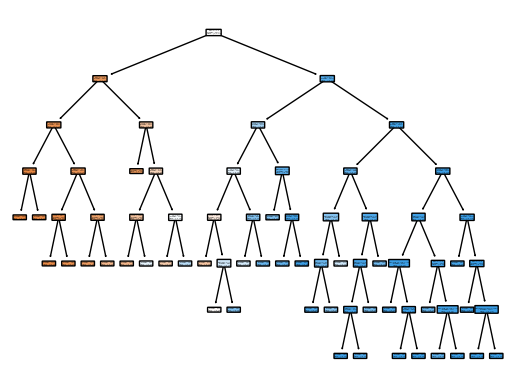

In [246]:

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)


# Naive classifier

In [247]:
X_train_naive = X_train.iloc[:, -1].values.reshape(-1, 1)
X_test_naive = X_test.iloc[:, -1].values.reshape(-1, 1)

Accuracy: 0.886436993610434
auROC: 0.8765211459388754
[[  720   112]
 [ 1612 12737]]


[Text(0.5, 0.75, 'beds_over_15_100k <= 0.0\nsamples = 39106\nvalue = [24.0, 24.0]\nclass = Above'),
 Text(0.25, 0.25, 'samples = 8073\nvalue = [20.0, 3.0]\nclass = Below'),
 Text(0.75, 0.25, 'samples = 31033\nvalue = [4.0, 22.0]\nclass = Above')]

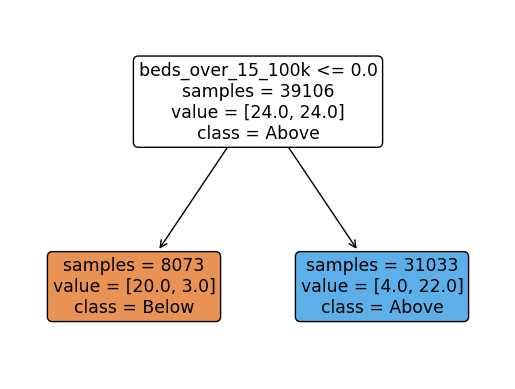

In [248]:
param_grid = {
    'criterion': [ 'entropy'],
    'max_depth': np.arange(2, 5),
    'min_samples_split':  np.arange(100, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train_naive, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train_naive, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test_naive)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=[ 'beds_over_15_100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)


In [249]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.8876576764931354
specificity:  0.8653846153846154
ppv:  0.991283368355514
npv:  0.30874785591766724


In [250]:
model_name = f"Naive_auroc_{ROC:.4f}_delta_period_unpruned.sav"
pickle.dump(clf, open(model_name, 'wb'))

# Omicron

In [251]:
start_date = pd.to_datetime('2021-12-01')
end_date = pd.to_datetime('2022-09-20')
data_by_HSA['date'] = pd.to_datetime(data_by_HSA['date'])
for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_HSA.loc[data_by_HSA['date'] <= start_date].index.max()
matching_indices_end = data_by_HSA.loc[data_by_HSA['date'] <= end_date].index.max()
first_week_omicron = data_by_HSA.loc[matching_indices_start, 'week']
last_week_omicron = data_by_HSA.loc[matching_indices_end, 'week']

In [252]:
X_train, y_train, weights, missing_data_train_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(1, first_week_omicron -2), weeks_in_future = 3,  geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test, y_test, weights_test, missing_data_test_HSA = prep_training_test_data_period(all_HSA_ID_weekly_data,   no_weeks = range(first_week_omicron -1, last_week_omicron-2), weeks_in_future = 3,  geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights = weights[0]

Accuracy: 0.8524718397997497
auROC: 0.8637165659018814
[[ 4317   589]
 [ 4126 22928]]


[Text(0.41983695652173914, 0.9375, 'beds <= 21.0\nsamples = 55086\nvalue = [34.0, 34.0]\nclass = Below'),
 Text(0.23369565217391305, 0.8125, 'beds <= 10.0\nsamples = 13485\nvalue = [31.0, 6.0]\nclass = Below'),
 Text(0.16304347826086957, 0.6875, 'admits <= 2.0\nsamples = 8761\nvalue = [26.0, 3.0]\nclass = Below'),
 Text(0.08695652173913043, 0.5625, 'cases <= 24.0\nsamples = 5505\nvalue = [19.0, 1.0]\nclass = Below'),
 Text(0.043478260869565216, 0.4375, 'deaths <= 0.0\nsamples = 1950\nvalue = [8.0, 0.0]\nclass = Below'),
 Text(0.021739130434782608, 0.3125, 'samples = 768\nvalue = [4.0, 0.0]\nclass = Below'),
 Text(0.06521739130434782, 0.3125, 'samples = 1182\nvalue = [5.0, 0.0]\nclass = Below'),
 Text(0.13043478260869565, 0.4375, 'beds <= 0.0\nsamples = 3555\nvalue = [11.0, 1.0]\nclass = Below'),
 Text(0.10869565217391304, 0.3125, 'cases <= 132.0\nsamples = 3137\nvalue = [10.0, 1.0]\nclass = Below'),
 Text(0.08695652173913043, 0.1875, 'deaths <= 0.0\nsamples = 2322\nvalue = [8.0, 1.0]\n

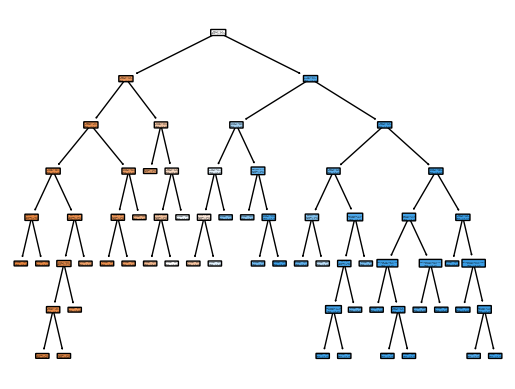

In [253]:
param_grid = {
    'criterion': [ 'entropy'],
    'max_depth': np.arange(2, 20),
    'min_samples_split':  np.arange(100, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)


In [254]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.847490204775634
specificity:  0.8799429270281288
ppv:  0.9749542883871242
npv:  0.5113111453274902


In [255]:
model_name = f"Full_auroc_{ROC:.4f}_omicron_period_unpruned.sav"
pickle.dump(clf, open(model_name, 'wb'))

In [256]:
model_name = "/Users/rem76/Documents/COVID_projections/COVID_forecasting/Full_auroc_0.8637_omicron_period_unpruned.sav"
clf = pickle.load(open(model_name, 'rb'))


In [257]:
unpruned_tree = clf
# Calculate impurity-based CCP alphas
path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Perform cross-validation for different alpha values
best_alpha = None
best_score = 0
for alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(ccp_alpha=alpha)
    scores = cross_val_score(pruned_tree, X_train, y_train, cv=cv)  # Use your desired cross-validation strategy
    mean_score = np.mean(scores)
    
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print("Best alpha:", best_alpha)

Best alpha: 0.0005715488709076664


In [261]:
clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, min_samples_leaf=150, min_samples_split=1700,
                       random_state=10, ccp_alpha=best_alpha)

Accuracy: 0.8524718397997497
auROC: 0.8637165659018814
[[ 4317   589]
 [ 4126 22928]]


[Text(0.3717948717948718, 0.9375, 'beds <= 21.0\nsamples = 55086\nvalue = [34.0, 34.0]\nclass = Below'),
 Text(0.16666666666666666, 0.8125, 'beds <= 10.0\nsamples = 13485\nvalue = [31.0, 6.0]\nclass = Below'),
 Text(0.10256410256410256, 0.6875, 'admits <= 2.0\nsamples = 8761\nvalue = [26.0, 3.0]\nclass = Below'),
 Text(0.05128205128205128, 0.5625, 'cases <= 24.0\nsamples = 5505\nvalue = [19.0, 1.0]\nclass = Below'),
 Text(0.02564102564102564, 0.4375, 'samples = 1950\nvalue = [8.0, 0.0]\nclass = Below'),
 Text(0.07692307692307693, 0.4375, 'beds <= 0.0\nsamples = 3555\nvalue = [11.0, 1.0]\nclass = Below'),
 Text(0.05128205128205128, 0.3125, 'samples = 3137\nvalue = [10.0, 1.0]\nclass = Below'),
 Text(0.10256410256410256, 0.3125, 'samples = 418\nvalue = [1.0, 0.0]\nclass = Below'),
 Text(0.15384615384615385, 0.5625, 'cases <= 74.0\nsamples = 3256\nvalue = [7.0, 1.0]\nclass = Below'),
 Text(0.1282051282051282, 0.4375, 'samples = 1977\nvalue = [5.0, 1.0]\nclass = Below'),
 Text(0.1794871794

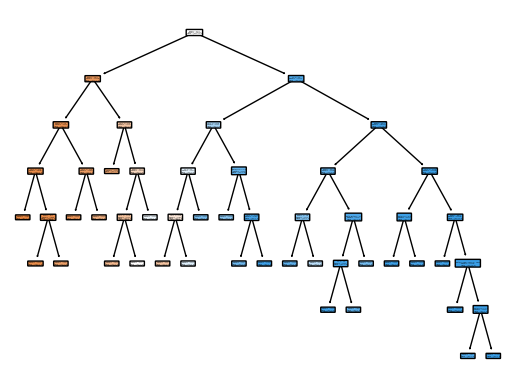

In [262]:

# Train the decision tree classifier
clf.fit(X_train, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=['cases','delta_cases', 'deaths', 'delta_deaths', 'admits', 'delta_admits', 'icu', 'delta_icu',  'beds', 'delta_beds' 'perc_covid', 'delta_perc', 'beds_over_15_100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)


# Naive classifier

In [236]:
X_train_naive = X_train.iloc[:, -1].values.reshape(-1, 1)
X_test_naive = X_test.iloc[:, -1].values.reshape(-1, 1)

Accuracy: 0.8694618272841051
auROC: 0.8545621233563734
[[ 4087   819]
 [ 3353 23701]]


[Text(0.5, 0.75, 'beds_over_15_100k <= 0.0\nsamples = 55086\nvalue = [34.0, 34.0]\nclass = Below'),
 Text(0.25, 0.25, 'samples = 10798\nvalue = [29.0, 4.0]\nclass = Below'),
 Text(0.75, 0.25, 'samples = 44288\nvalue = [5.0, 30.0]\nclass = Above')]

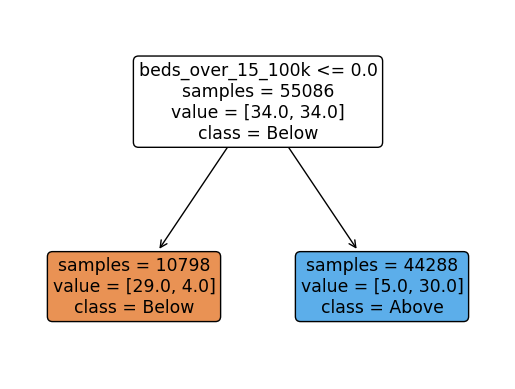

In [237]:
param_grid = {
    'criterion': [ 'entropy'],
    'max_depth': np.arange(2, 5),
    'min_samples_split':  np.arange(100, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(100, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)}


# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

clf = DecisionTreeClassifier(random_state=10, class_weight='balanced')

# Perform Randomized Search with 10-fold cross-validation
random_search = RandomizedSearchCV(clf, param_grid, n_iter=50, cv=cv, random_state=10)
random_search.fit(X_train_naive, y_train, sample_weight = weights)

best_params = random_search.best_params_

# Create the Decision Tree classifier with the best hyperparameters
clf = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')

# Train the decision tree classifier
clf.fit(X_train_naive, y_train[0],  sample_weight = weights)

# Make predictions on the test set
y_pred = clf.predict(X_test_naive)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
ROC = roc_auc_score(y_test[0], y_pred)

print("Accuracy:", accuracy)
print("auROC:", ROC)

print(confusion_matrix(y_test, y_pred))
plot_tree(clf,feature_names=[ 'beds_over_15_100k'], class_names=['Below', 'Above'], filled=True, impurity=False, proportion=False, rounded=True, precision=0)


In [238]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

sensitivity:  0.8760626894359429
specificity:  0.8330615572768039
ppv:  0.9665986949429037
npv:  0.5493279569892473
